In [19]:
import numpy as np
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from blackjack_count import BlackjackCountEnv

In [2]:
NUM_DECKS = 4

## Q-Learning

In [3]:
def get_bin(state):
    return [min(state[0] - 4, 17), state[1] - 2, int(state[2]), state[3], state[4]]

Q = np.array([[[[[[np.random.uniform(-0.001, 0.001) for action in range(2)] \
                    for ten in range(NUM_DECKS * 16 + 1)] \
                    for ace in range(NUM_DECKS*4 + 1)] \
                    for usable_ace in range(2)] \
                    for dealer_val in range(10)] \
                    for player_val in range(18)])

In [4]:
gamma = 0.99

def Q_learning(game, alpha, epsilon):
    
    S, reward, over = game.play()
    S = get_bin(S)

    while not over:

        if np.random.binomial(1, epsilon):
            A = np.random.randint(2)
        else:
            A = np.argmax(Q[S[0]][S[1]][S[2]][S[3]][S[4]])

        S_prime, reward, over = game.step(A)
        S_prime = get_bin(S_prime)

        d = reward + gamma*(np.max(Q[S_prime[0]][S_prime[1]][S_prime[2]][S_prime[3]][S_prime[4]]))*(not over) \
              - Q[S[0]][S[1]][S[2]][S[3]][S[4]][A]
        Q[S[0]][S[1]][S[2]][S[3]][S[4]][A] += alpha * d

        S = S_prime
    
    return reward

In [ ]:
N = 2000000

Q_results = np.ndarray(N)

Q = np.array([[[[[[np.random.uniform(-0.001, 0.001) for action in range(2)] \
                for ten in range(NUM_DECKS * 16 + 1)] \
                for ace in range(NUM_DECKS*4 + 1)] \
                for usable_ace in range(2)] \
                for dealer_val in range(10)] \
                for player_val in range(18)])
epsilon = 1
game = BlackjackCountEnv(NUM_DECKS)

for epi in range(N):
    epsilon = max(0.0001, epsilon - 1/(N*1/2))
    Q_results[epi] = Q_learning(game, 0.001, epsilon)
    if epi % (N/100) == 0: print(int(epi*100/N))

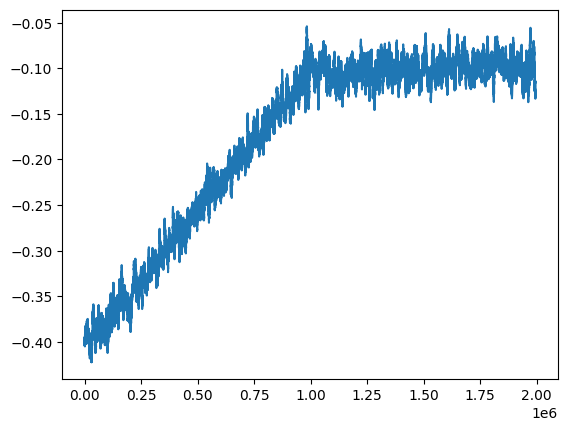

In [6]:
rolling_length = 5000

plt.plot(np.convolve(Q_results, np.ones(rolling_length), mode="valid") / rolling_length)
plt.show()

## SARSA

In [14]:
gamma = 0.99

Q = np.array([[[[np.random.uniform(-0.001, 0.001) for action in range(2)] \
                    for usable_ace in range(2)] \
                    for dealer_val in range(10)] \
                    for player_val in range(18)])

def SARSA(game, alpha, epsilon):
    S, reward, over = game.play()
    S = get_bin(S)

    while not over:

        if np.random.binomial(1, epsilon):
            A = np.random.randint(2)
        else:
            A = np.argmax(Q[S[0]][S[1]][S[2]][S[3]][S[4]])

        S_prime, reward, over = game.step(A)
        S_prime = get_bin(S_prime)
        
        if np.random.binomial(1, epsilon):
            A_prime = np.random.randint(2)
        else:
            A_prime = np.argmax(Q[S_prime[0]][S_prime[1]][S_prime[2]][S_prime[3]][S_prime[4]])

        d = reward + gamma*(Q[S_prime[0]][S_prime[1]][S_prime[2]][S_prime[3]][S_prime[4]][A_prime])*(not over) \
              - Q[S[0]][S[1]][S[2]][S[3]][S[4]][A]
        Q[S[0]][S[1]][S[2]][S[3]][S[4]][A] += alpha * d

        S = S_prime
    
    return reward

In [ ]:
N = 2000000

SARSA_results = np.ndarray(N)

Q = np.array([[[[[[np.random.uniform(-0.001, 0.001) for action in range(2)] \
                for ten in range(NUM_DECKS * 16 + 1)] \
                for ace in range(NUM_DECKS*4 + 1)] \
                for usable_ace in range(2)] \
                for dealer_val in range(10)] \
                for player_val in range(18)])
epsilon = 1
game = BlackjackCountEnv(NUM_DECKS)

for epi in range(N):
    epsilon = max(0.0001, epsilon - 1/(N*1/2))
    SARSA_results[epi] = SARSA(game, 0.001, epsilon)
    if epi % (N/100) == 0: print(int(epi*100/N))

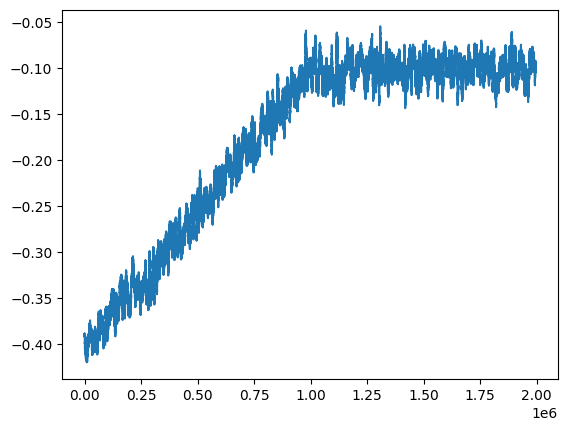

In [16]:
rolling_length = 5000

plt.plot(np.convolve(SARSA_results, np.ones(rolling_length), mode="valid") / rolling_length)
plt.show()

## DQN

In [20]:
class Memory():
	def __init__(self, capacity):
		self.capacity = capacity
		self.memory = []
		self.position = 0

	def push(self, transition):
		if len(self.memory) < self.capacity:
			self.memory.append(transition)
		else:
			self.memory[self.position] = transition
			self.position = (self.position + 1) % self.capacity

	def sample(self, batchsize):
		return random.sample(self.memory, batchsize)
	
class DQN(nn.Module):
	
    def __init__(self):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(5, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, 2)
		
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)



In [21]:

BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 1
EPS_END = 0.005
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

policy = DQN().to(device)
target = DQN().to(device)
optimizer = optim.SGD(policy.parameters(), lr=LR)
memory = Memory(20000)


In [22]:
steps = 0
threshold = 1
def select_action(state):
    global steps, threshold
    # threshold =  EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps / EPS_DECAY)
    threshold = max(0.01, threshold - 1/(200000/2))
    steps += 1
    if np.random.rand() > threshold:
        with torch.no_grad():
            return policy(state).max(1)[1].view(1,1)
    else: 
        return torch.tensor([[np.random.choice(2)]], device=device, dtype=torch.long)
    
def optimize_model():
    if len(memory.memory) < BATCH_SIZE: return

    sample = memory.sample(BATCH_SIZE)
    batch = list(zip(*sample))
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch[2])), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch[2] if s is not None])
    state_batch = torch.cat(batch[0])
    action_batch = torch.cat(batch[1])
    reward_batch = torch.cat(batch[3])
    
    state_action_values = policy(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad(): next_state_values[non_final_mask] = target(non_final_next_states).max(1)[0]
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    loss = nn.SmoothL1Loss()(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(policy.parameters(), 100)
    optimizer.step()





In [ ]:
DQN_results = np.ndarray((200000))


game = BlackjackCountEnv(4)

for epi in range(200000):
    state, reward, over = game.play()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    
    while not over:
        action = select_action(state)
        next_state, reward, over = game.step(action)
        reward = torch.tensor([reward], device=device)

        next_state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0) if not over else None
        memory.push((state, action, next_state, reward))

        state = next_state

        optimize_model()

        target_state_dict = target.state_dict()
        policy_state_dict = policy.state_dict()
        for key in policy_state_dict:
            target_state_dict[key] = policy_state_dict[key]*TAU + target_state_dict[key]*(1-TAU)
        target.load_state_dict(target_state_dict)
    
    if epi % 1000 == 0: print(epi)

    DQN_results[epi] = reward

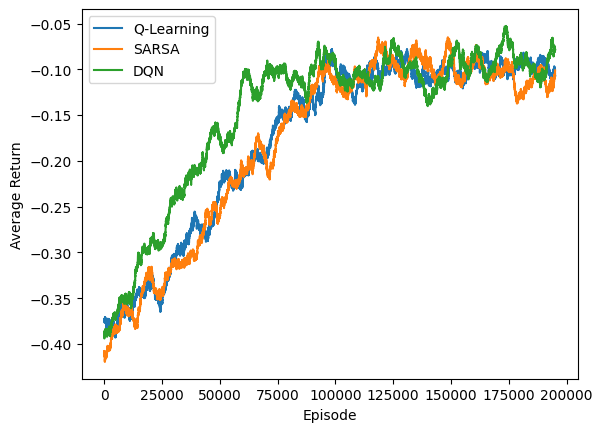

In [28]:
rolling_length = 5000
plt.plot(np.convolve(Q_results[::10], np.ones(rolling_length), mode="valid") / rolling_length, label='Q-Learning')
plt.plot(np.convolve(SARSA_results[::10], np.ones(rolling_length), mode="valid") / rolling_length, label='SARSA')
plt.plot(np.convolve(DQN_results, np.ones(rolling_length), mode="valid") / rolling_length, label='DQN')

plt.xlabel('Episode')
plt.ylabel('Average Return')
plt.legend()
plt.show()